### Todo

We could add Outlier removal to preprocessing

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [2]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
# os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/Trond/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


# Joined imputed data to import, 0 = MODE/MEAN IMPUTATION, 1 = SIMILARITY MEASURE
MV_FLAG = 1

#The portion of data in the test set
TEST_PORTION = 0.2

#### In this cell we import our joined imputed data based on MV_FLAG

In [3]:
if MV_FLAG == 0:
    data = pd.read_csv('joined_data_mm.csv') # missing values filled with mean/median
else: 
    data = pd.read_csv('joined_data_heom.csv') # missing values filled based on HEOM measure



#### In this cell we define the functions we need to calculate derived values from various variables

In [4]:
#Functions for calculating derived values for various data tables

def vlttot (df):
    ''' Semantic Fluency
    VLTANIM, VLTVEG,VLTFRUIT need to be summed in order to obtain a final score'''
    
    component_vars = ["VLTANIM", "VLTVEG", "VLTFRUIT"]
    
    df['VLTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def remqtot (df):
    '''REM sleep behavior disorder (RBD)'''
    
    component_vars = ["STROKE","HETRA", "PARKISM", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM", "CNSOTH"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # 1 point if any of these component variables had a 1, else 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)

    component_vars = ["DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", \
                      "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB"]
    
    score += df.loc[:, component_vars].sum(axis = 1, skipna = False)

    df['REMTOT'] = score
    df.drop(component_vars, inplace = True, axis = 1)

    
def gdsstot (df):
    '''Geriatric Depression Scale'''
    
    component_vars = ["GDSSATIS", "GDSDROPD", \
    "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", \
    "GDSHOPLS", "GDSBETER"]
    
    df['GDSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def sidttot (df):
    '''Olfactory impairment: University of Pennsylvania Smell ID Test'''
    component_vars = ["UPSITBK1", "UPSITBK2", "UPSITBK3", "UPSITBK4"]
    
    df['SIDTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def epsstot (df):
    '''Epworth Sleepiness Scale'''
    
    component_vars = ["ESS1", "ESS2", \
    "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"]
    
    df['EPSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def scoptot(df):
    '''Scales for Outcomes in Parkinson’s Disease–Autonomic'''

    component_vars = ["SCAU1", "SCAU2", \
    "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", \
    "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU24", "SCAU25"]
    
    df['SCOPTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    

def msu3tot(df):
    '''Movement Disorders Society–Unified Parkinson Disease Rating Scale'''
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', 'NP3LGAGR', 'NP3RIGLU']
       
    df['MSU3TOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd

    
def tremor(df):
    '''Tremor score'''
    
    component_vars = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", \
    "NP3RTALJ", "NP3RTCON"]
    
    df['TREMOR'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd
    
    
def pigd(df):
    '''PIGD score'''
    
    component_vars = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    df['PIGD'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', "NP2TRMR", "NP2WALK", "NP2FREZ", 'NP3LGAGR', 'NP3RIGLU']
    #cannot drop before we discuss missing values
    df.drop(component_vars, inplace = True, axis = 1) #drop everything from msu3tot, tremor and pig
    

def td_pigd_ratio(df):
    '''Tremor/PIGD ratio'''
    
    component_vars = ['TREMOR', 'PIGD']
    df['TD_PIGD_RATIO'] = df.apply(lambda x: ratio(x['TREMOR'], x['PIGD']), axis=1)
    df.drop(component_vars, inplace = True, axis = 1)

    
def ratio(x, y):
    ''' Calculate TD/PGID ratio'''
    
    if y == 0:
        if x == 0:
            ratio = 0 #indeterminate
        else: 
            ratio =1 #TD
    elif x/y >= 1.15:
        ratio = 1 #TD
    elif x/y <= 0.9:
        ratio = 2 #PIGD
    else:
        ratio = 0 #indeterminate 
    return ratio

#### In this cell we define functions for encoding and dichotomizing variables

In [5]:
#Functions for encoding and dichotomizing variables

def famhist(df):
    '''Family history of Parkinson's Disease'''
    
    component_vars = ["BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # if score >= 1 then 1, else 0
    # if score = NaN, then 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)
    df['FAMHIST'] = score
    
    
def sleepy(df):
    '''Dichotomize EPSSTOT, Epworth Sleepiness Scale'''
    
    # if score < 10 subjects will be classified as 0 (not sleepy)
    # if score >= 10 subject will be classified as 1 (sleepy).
    df['SLEEPY'] = df['EPSSTOT'].apply(lambda x: np.where(x >=10, 1, 0))

    df.drop('EPSSTOT', inplace = True, axis = 1)


def depr(df):
    '''Dichotomize GDSSTOT, Geriatric Depression Scale'''
    
    # if score <5 subjects will be classified as 0 (non-depressed).
    # if score >= 5 subjects will be classified as 1 (depressed) 
    df['DEPR'] = df['GDSSTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('GDSSTOT', inplace = True, axis = 1)


def rbd(df):
    '''Dichotomize REMTOT, REM sleep behavior disorder (RBD)'''
       
    # if score <5 subjects will be classified as 0 (RBD negative).
    # if score >= 5 subjects will be classified as 1 (RBD positive) 
    df['RBD'] = df['REMTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('REMTOT', inplace = True, axis = 1)
    

def hall(df):
    '''Dihotomize NP1HALL dependent variable'''
    
    # if the patient has not suffered hallucinations, we consider it 0
    # if the patient has suffered >= 1 times hallucinations, we consider it 1   
    df['HALL'] = df['NP1HALL'].apply(lambda x: np.where(x >=1, 1, 0))

    df.drop('NP1HALL', inplace = True, axis = 1)


#### All preprocessing functions together

In [6]:
def preprocess(df):
    '''All preprocessing together'''
    vlttot(df)
    remqtot(df)
    gdsstot(df)
    sidttot(df)
    epsstot(df)
    scoptot(df)
    msu3tot(df)
    tremor(df)
    pigd(df)
    td_pigd_ratio(df)
    famhist(df)
    sleepy(df)
    depr(df)
    rbd(df)
    hall(df)    

#### In this cell we apply our preprocessing functions on the data and inspect the final data table, including correlations between features

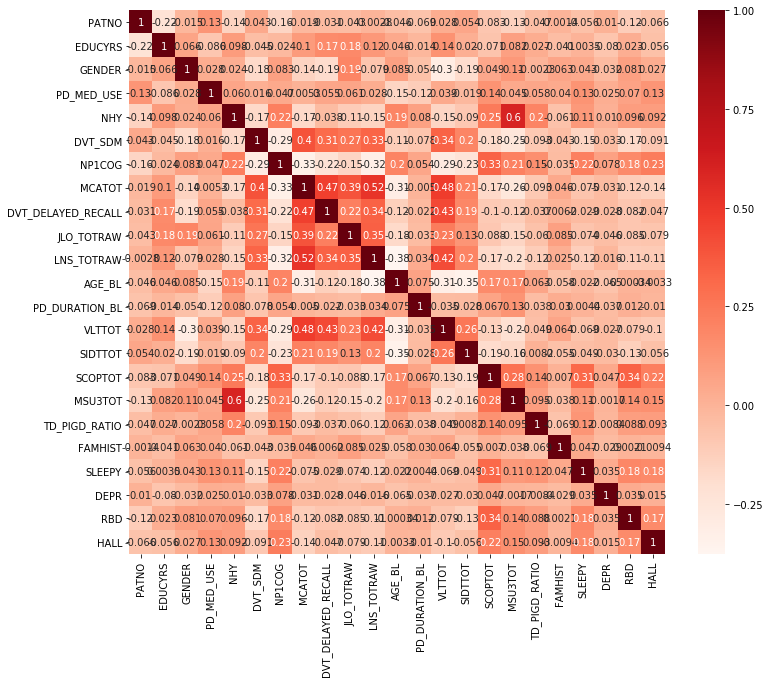

In [7]:
preprocess(data)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### In this cell we seperate out data set into training and test sets and apply standardization to numeric columns

In [8]:
#We have to ensure that all longitudinal observations from one patient ends up in the same sample
tempdata = pd.DataFrame(data.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in data.PATNO.unique():

    if data.loc[(data.PATNO == id) & (data.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

print("Number of patients which hallucinates eventually: ",  sum(HALL_EVER), " which is ", sum(HALL_EVER)/ len(HALL_EVER), " percent of patients" )
    
Y = HALL_EVER
X = tempdata


train, test, _, _ = train_test_split( X, Y, test_size= TEST_PORTION, random_state= 1, stratify= Y)

train = data.merge(train, how = "inner", on = "PATNO")
test = data.merge(test, how = "inner", on = "PATNO")

Number of patients which hallucinates eventually:  114  which is  0.27014218009478674  percent of patients


#### In this cell we apply standardization to numeric columns and output train and test to disk

In [9]:
def standardize_df (df, standardization):
    
    pd.set_option('mode.chained_assignment', None)
    columns = standardization.loc[:, "COLUMN_NAME"].values
    for i,c in enumerate(columns):
        df.loc[:,c] -= standardization.at[i,"MEAN"]
        df.loc[:,c] /= standardization.at[i,"STD"]
        
    pd.set_option('mode.chained_assignment', "warn")


column_types = pd.read_csv("Column_Data_Types_Final.csv")

numeric_columns = column_types.loc[column_types.DATA_TYPE == "Numeric", "COLUMN_NAME"].values

mean = np.mean(train.loc[:, numeric_columns])
std = np.std(train.loc[:, numeric_columns])

standardization = pd.DataFrame(numeric_columns, columns = ["COLUMN_NAME"])
standardization["MEAN"] = mean.values
standardization["STD"] = std.values

#Saving the standardization so we can later apply to test data
standardization.to_csv(output_filepath + '/standardization.csv', index = False)

standardize_df(train, standardization)

#Output train and test to disk

train.to_csv(output_filepath + '/train.csv', index = False)
test.to_csv(output_filepath + '/test.csv', index = False)


